In [2]:
import sys
print(sys.version_info)
assert sys.version_info >= (3, 7)

from packaging import version
import sklearn
print ("Scikit-Learn version: ", sklearn.__version__)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

sys.version_info(major=3, minor=11, micro=4, releaselevel='final', serial=0)
Scikit-Learn version:  1.3.0


In [3]:
import matplotlib.pyplot as plt

def plot_digit(image_data, axis=False):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")

    if not axis:
        plt.axis("off")

In [4]:
def plot_multi(img,start=0,end=100):
    plt.figure(figsize=(9, 9))
    for idx, image_data in enumerate(img[start:end]):
        plt.subplot(10, 10, idx + 1)
        plot_digit(image_data)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [5]:
from pathlib import Path

# this is where the datasets are located
path = Path() / "dataset_cleaned"
print(path)

dataset_cleaned


In [6]:
# your training datasets
# must be cleaned

my_data_num = np.load(path / "digit_data_TrVal_relabeled_v2.npz")
my_data_sym = np.load(path / "op_data_TrVal_relabeled_v2.npz")

In [7]:
def rebase_center(img):
    r = 28
    c = 28

    # each boundary
    r_top = r
    r_bot = -1
    c_left = c
    c_right = -1

    for n in range(r):
        for m in range(c):
            
            # if the pixel has whatever value
            if img[n][m] != 0:
                # update the boundary
                r_top = min(r_top, n)
                r_bot = max(r_bot, n)
                c_left = min(c_left, m)
                c_right = max(c_right, m)
    
    # print(r_top,r_bot,c_left,c_right)
    
    c_len = c_right - c_left + 1
    r_len = r_bot - r_top + 1

    c_start = int((c - c_len) / 2)
    r_start = int((r - r_len) / 2)

    # print(c_len,r_len,c_start,r_start)

    rebased_data = np.zeros((r,c),dtype="float64")

    # rebase into a center
    rebased_data[r_start:r_start+r_len, c_start:c_start+c_len] = img[r_top:r_bot+1, c_left:c_right+1]
    
    return rebased_data

In [8]:
def detect_del_boundary(img, thickness = 4, threshold = 10):
    curr = np.reshape(img,(28,28))
    
    # how much you want to look at
    t = thickness
    # the threshold
    threshold_t = threshold
    
    for i in range(thickness):
        cnt_top = np.count_nonzero(curr[i:i+1,:])
        cnt_down = np.count_nonzero(curr[28-i:28-i+1,:])
        cnt_left = np.count_nonzero(curr[:,i:i+1])
        cnt_right = np.count_nonzero(curr[:,27-i:27-i+1])
        
        if cnt_top > threshold_t:
            curr[0:t,:] = 0.
        
        if cnt_down > threshold_t:
            curr[28-t:28,:] = 0.
        
        if cnt_left > threshold_t:
            curr[:,0:t] = 0.
            
        if cnt_right > threshold_t:
            curr[:,28-t:28] = 0.
    
    return curr

In [9]:
def dfs(r,c,img, visited):
    st = list()
    st.append([r,c])
    
    cord = [[1,1],[1,0],[1,-1],[0,1],[0,-1],[-1,1],[-1,0],[-1,-1]]
    
    dot = list()
    
    while st:
        curr = st.pop()
        
        if visited[curr[0]][curr[1]] == 1.: continue
        
        dot.append(curr)
        visited[curr[0]][curr[1]] = 1.
        
        for n,m in enumerate(cord):
            row = curr[0] + m[0]
            col = curr[1] + m[1]
            
            if 0 <= row < 28 and 0 <= col < 28:
                if img[row][col] != 0. and visited[row][col] == 0.:
                    st.append([row,col])
            
    
    return dot,visited

In [10]:
def d_deletion(img, dot_size = 4):
    
    # to check whether we visited
    isVisited = np.full((28,28),0.)
    
    # dots that needs to be deleted afterwards
    dots = list()
    
    for i in range(28):
        for j in range(28):
            if img[i][j] != 0. and not isVisited[i][j]:
                dot, isVisited = dfs(i,j,img,isVisited)
                
                if len(dot) <= dot_size:
                    dots.extend(dot)
    
    
        for n,m in enumerate(dots):
            img[m[0],m[1]] = 0.
    
    return img

In [11]:
def resize(img,size=18):
    r = 28
    c = 28
    
    # each boundary
    r_top = r
    r_bot = -1
    c_left = c
    c_right = -1
    
    for n in range(r):
        for m in range(c):
            
            # if the pixel has whatever value
            if img[n][m] != 0:
                # update the boundary
                r_top = min(r_top, n)
                r_bot = max(r_bot, n)
                c_left = min(c_left, m)
                c_right = max(c_right, m)
                
    row_len = r_bot - r_top + 1
    col_len = c_right - c_left + 1
    
    adjusted_img = img[r_top:r_bot+1,c_left:c_right+1]
    
    diff = abs(row_len - col_len)
    
    top_pad = int(diff / 2)
    down_pad = int(diff / 2)
    
    if diff % 2 == 1:
        top_pad += 1
    
    if row_len > col_len:
        adjusted_img = np.pad(adjusted_img, pad_width=((0,0),(top_pad,down_pad)), mode="constant")
            
    else:
        adjusted_img = np.pad(adjusted_img, pad_width=((top_pad,down_pad),(0,0)), mode="constant")         
        

    import cv2
    
    try:
        # using inter_nearest
        resized_img = cv2.resize(adjusted_img, dsize=(size,size),interpolation=0)
    except:
        return img
    
    resized_img = np.pad(resized_img,int((28 - size)/2),mode="constant")
    
    return resized_img

In [12]:
def preprocessing(img, rebase=True, b_del=True, d_del=True, re_size=True, one_array=True):
    size = np.shape(img)[0]
    
    # row and column length
    r = 28
    c = 28
    
    # reshape to 2-d array(for convenience)
    img_preprocessed = np.reshape(img,(size,r,c))
    
    # rebase
    if rebase:
        print("rebase ongoing")
        
        for x in range(size):
            img_preprocessed[x] = rebase_center(img_preprocessed[x])
        print("done!")
    
    # border deletion
    if b_del:
        print("border deletion ongoing")
        
        for x in range(size):
            img_preprocessed[x] = detect_del_boundary(img_preprocessed[x],thic,thres)
            
        print("done!")
    
    # dot deletion
    if d_del:
        print("dot deletion ongoing")
        
        for x in range(size):
            img_preprocessed[x] = d_deletion(img_preprocessed[x],dot_size=siz)
            
        print("done!")
    
    # resize
    if re_size:
        print("resize ongoing")
        
        for x in range(size):
            img_preprocessed[x] = resize(img_preprocessed[x])
        
        print("done!")
    
    return np.reshape(img_preprocessed,(size,r*c)) if one_array else np.reshape(img_preprocessed,(size,r,c))

so we have completed our preprocessing, but we have not actually tested each parameter
so here similar to the **gridSearchCV()**, we shall try numerous values to the parameter and get the best one

In [13]:
my_data_combine_img = np.concatenate((my_data_num["img"],my_data_sym["img"]),axis=0)
my_data_combine_label = np.concatenate((my_data_num["label"],my_data_sym["label"]),axis=0)


## basic

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

random = 42

nn_clf = make_pipeline(RobustScaler(), MLPClassifier(random_state=random,solver="lbfgs",max_iter=500))
nn_clf_adam = make_pipeline(RobustScaler(), MLPClassifier(random_state=random,solver="adam",max_iter=500))

In [15]:
nn_clf.fit(my_data_combine_img.reshape(-1,784),my_data_combine_label)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('mlpclassifier',
                 MLPClassifier(max_iter=500, random_state=42, solver='lbfgs'))])

In [16]:
from sklearn.model_selection import cross_val_score

# lbfgs

cross_val_score(nn_clf, my_data_combine_img.reshape(-1,784), my_data_combine_label, cv=3,n_jobs=-1)

array([0.65917603, 0.65878179, 0.6620343 ])

In [17]:
test = cross_val_score(nn_clf, my_data_combine_img.reshape(-1,784), my_data_combine_label, cv=3,n_jobs=-1).mean()

In [18]:
test.dtype

dtype('float64')

In [19]:
# adam

nn_clf_adam.fit(my_data_combine_img.reshape(-1,784),my_data_combine_label)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('mlpclassifier',
                 MLPClassifier(max_iter=500, random_state=42))])

In [20]:
cross_val_score(nn_clf_adam, my_data_combine_img.reshape(-1,784), my_data_combine_label, cv=3,n_jobs=-1)

array([0.6696235 , 0.66154149, 0.67602996])

adam is slightly better, we shall use that value for now

## rebase

rebase has no parameters, we shall just check its **cross_val_score** to check the improvement

In [21]:
my_data_num_img_rebase = preprocessing(my_data_combine_img,True,False,False,False,True)

nn_clf_adam.fit(my_data_num_img_rebase,my_data_combine_label)
cross_val_score(nn_clf_adam, my_data_num_img_rebase, my_data_combine_label, cv=3,n_jobs=-1)


rebase ongoing
done!


array([0.79262764, 0.79893554, 0.78553124])

## border del

In [22]:
size = my_data_combine_img.shape[0]

In [23]:
thick = [3,4,5]
threshold = [10,15,20]

best_score = 0
best_thick= 0
best_threshold= 0

my_data_save_0 = my_data_combine_img.copy()

for x in range(size):
    my_data_save_0[x] = rebase_center(my_data_save_0[x])

for i,j in enumerate(thick):
    for n,m in enumerate(threshold):
        my_data_border = my_data_save_0.copy()
        
        for x in range(size):
            my_data_border[x] = detect_del_boundary(my_data_border[x],j,m)
        
        my_data_border = my_data_border.reshape(-1,784)
        
        nn_clf_adam.fit(my_data_border,my_data_combine_label)
        score_mean = cross_val_score(nn_clf_adam, my_data_border, my_data_combine_label, cv=3,n_jobs=-1).mean()
        
        print(f"result in {j} thickness and {m} threshold: {score_mean}")
        
        if score_mean > best_score:
            best_score = score_mean
            best_thick = j
            best_threshold = m

print(f"best result is {best_score} at thickness: {best_thick}, and threshold: {best_threshold}")

result in 3 thickness and 10 threshold: 0.7919377094421448
result in 3 thickness and 15 threshold: 0.7930218805440568
result in 3 thickness and 20 threshold: 0.7919377094421446
result in 4 thickness and 10 threshold: 0.7917077337538604
result in 4 thickness and 15 threshold: 0.7898679282475852
result in 4 thickness and 20 threshold: 0.7899007819173401
result in 5 thickness and 10 threshold: 0.7871739273276824
result in 5 thickness and 15 threshold: 0.7900321965963598
result in 5 thickness and 20 threshold: 0.7912806360470465
best result is 0.7930218805440568 at thickness: 3, and threshold: 15


## dot deletion

In [24]:
dot = [2,3,4,5,6,7]

best_score = 0
best_dot = 0

my_data_save_1 = my_data_combine_img.copy()

for x in range(size):
    my_data_save_1[x] = rebase_center(my_data_save_1[x])
    my_data_save_1[x] = detect_del_boundary(my_data_save_1[x],3,15)

for i,j in enumerate(dot):
    my_data_dot = my_data_save_1.copy()
        
    for y in range(size):
        my_data_dot[y] = d_deletion(my_data_dot[y],j)
        
    my_data_dot = my_data_dot.reshape(-1,784)
        
        
    nn_clf_adam.fit(my_data_dot,my_data_combine_label)
    score_mean = cross_val_score(nn_clf_adam, my_data_dot, my_data_combine_label, cv=3,n_jobs=-1).mean()
        
    print(f"result in {j} dot size: {score_mean}")
            
    if score_mean > best_score:
        best_score = score_mean
        best_dot = j
        
print(f"best result is {best_score} at dot size: {best_dot}")

result in 2 dot size: 0.7887837571456732
result in 3 dot size: 0.7886851961364084
result in 4 dot size: 0.7872396346671923
result in 5 dot size: 0.790295025954399
result in 6 dot size: 0.7882252447598397
result in 7 dot size: 0.7853998291609173
best result is 0.790295025954399 at dot size: 5


## resize

In [28]:
siz = [16,18,20]

my_data_save_2 = my_data_save_1.copy()

# for x in range(size):
#     my_data_save_2[x] = d_deletion(my_data_save_2[x],)

best_score = 0
best_size = 0

for i,j in enumerate(siz):
    my_data_resize = my_data_combine_img.copy()
    
    for z in range(size):
        my_data_resize[z] = resize(my_data_resize[z],size=j)
        
    my_data_resize = my_data_resize.reshape(-1,784)
        
    nn_clf_adam.fit(my_data_resize,my_data_combine_label)
    score_mean = cross_val_score(nn_clf_adam, my_data_resize, my_data_combine_label, cv=3,n_jobs=-1).mean()
        
    print(f"result in {j} size: {score_mean}")
            
    if score_mean > best_score:
        best_score = score_mean
        best_size = j
        
print(f"best result is {best_score} at size: {best_size}")

result in 16 size: 0.7994940534857745
result in 18 size: 0.8046520796372955
result in 20 size: 0.8072146658781786
best result is 0.8072146658781786 at size: 20


as the size of **resize()** affects the score as it gets larger, but we may need to match with the mnist. let's check mnist's size and match them

In [31]:
from sklearn.datasets import fetch_openml

openml = fetch_openml('mnist_784', as_frame=False,parser="auto")
mnist = openml

mnist_img = mnist.data
mnist_label = mnist.target

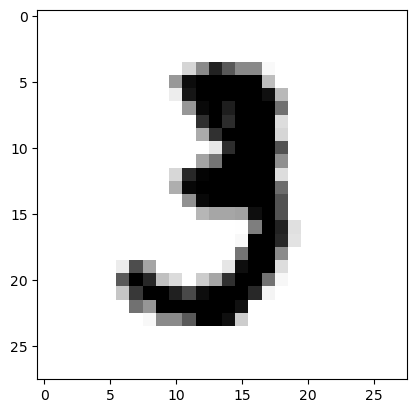

In [34]:
plot_digit(mnist_img[10],True)

about 20, so 20 shall do

## == handmade test from here ==

In [12]:
test_data = np.load("handmade_test.npz")

test_data_img = test_data["img"]
test_data_label = test_data["label"]

In [13]:
test_data_img.dtype

dtype('float64')

In [14]:
test_data_label.dtype

dtype('int32')

In [34]:
test_data_img.shape

(100, 28, 28)

In [51]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1,parser="auto")
mnist_images = (mnist.data.to_numpy() / 255).round()
mnist_labels = mnist.target.to_numpy()

In [52]:
mnist_images.dtype

dtype('float64')

In [59]:
mnist_images.shape

(70000, 784)

In [53]:
mnist_labels.astype(str)

array(['5', '0', '4', ..., '4', '5', '6'], dtype='<U1')

In [54]:
from sklearn.neural_network import MLPClassifier

nn_clf = MLPClassifier(random_state=42).fit(mnist_images,mnist_labels)

In [60]:
test_data_img = np.reshape(test_data_img,(-1,784))
test_data_img.shape

(100, 784)

In [56]:
test_data_label.astype(str)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '1', '2',
       '3', '4', '5', '6', '7', '8', '9', '0', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       '9', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '1',
       '2', '3', '4', '5', '6', '7', '8', '9', '0', '1', '2', '3', '4',
       '5', '6', '7', '8', '9', '0', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0',
       '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U11')

In [63]:
nn_clf.score(test_data_img.reshape(1,-1),test_data_label)

ValueError: X has 78400 features, but MLPClassifier is expecting 784 features as input.

In [64]:
nn_clf.predict(test_data_img[2].reshape(1,-1))

array(['4'], dtype='<U1')

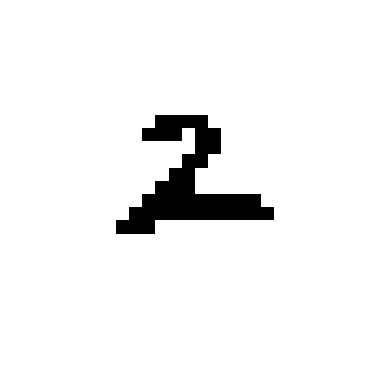

In [65]:
plot_digit(test_data_img[2])

In [47]:
print(f'hello')

hello


In [24]:
test = [10,11,12,13]

for i,j in enumerate(test):
    print(i,j)

0 10
1 11
2 12
3 13
